In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.spatial import cKDTree

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

## Create a ENSEMBLE and export as Netcdf

In [2]:
yy_s, yy_e = 2002, 2023
years_num = yy_e - yy_s + 1

npix = 2
acf = 'mar'
cor = 'pearson'

In [3]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
# dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_corrected')

In [7]:
Tr = [5,  10,  20,  50, 100, 200]
print(f'Return period: {Tr[3]}')

Return period: 50


In [8]:
# CMORPH data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_CM = xr.open_dataset(data_dir)
time_year = DATA_CM.year.values

lon2d_CM, lat2d_CM = np.meshgrid(DATA_CM.lon.values, DATA_CM.lat.values)

In [9]:
# ERA5 data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_ER = xr.open_dataset(data_dir)

lon2d_ER, lat2d_ER = np.meshgrid(DATA_ER.lon.values, DATA_ER.lat.values)

In [10]:
## GSMaP data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_GS = xr.open_dataset(data_dir)

lon2d_GS, lat2d_GS = np.meshgrid(DATA_GS.lon.values, DATA_GS.lat.values)

In [11]:
# MSWEP data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_MS = xr.open_dataset(data_dir)

lon2d_MS, lat2d_MS = np.meshgrid(DATA_MS.lon.values, DATA_MS.lat.values)

In [12]:
# IMERG data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_IM = xr.open_dataset(data_dir)
lat_IM = DATA_IM.lat.values
lon_IM = DATA_IM.lon.values

lon2d_IM, lat2d_IM = np.meshgrid(DATA_IM.lon.values, DATA_IM.lat.values)

In [13]:
## CHIRPS data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_CHIRPS_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_CH = xr.open_dataset(data_dir)
lat_CH = DATA_CH.lat.values
lon_CH = DATA_CH.lon.values

lon2d_CH, lat2d_CH = np.meshgrid(DATA_CH.lon.values, DATA_CH.lat.values)

In [14]:
def get_nearest_values(ref_lat2d, ref_lon2d, target_lat2d, target_lon2d, target_data):
    """
    Para cada punto en la malla de referencia, busca el valor más cercano en la malla objetivo.
    """
    ny, nx = ref_lat2d.shape
    ref_points = np.column_stack((ref_lat2d.ravel(), ref_lon2d.ravel()))
    target_points = np.column_stack((target_lat2d.ravel(), target_lon2d.ravel()))
    tree = cKDTree(target_points)
    _, idx = tree.query(ref_points)
    matched_values = target_data.ravel()[idx]
    return matched_values.reshape(ny, nx)

## NYd ENSEMBLE

In [18]:
ntimes = DATA_IM.NYd.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_NYd = DATA_IM.NYd.values[i, :, :]
    MS_NYd = DATA_MS.NYd.values[i, :, :]
    GS_NYd = DATA_GS.NYd.values[i, :, :]
    ER_NYd = DATA_ER.NYd.values[i, :, :]
    CM_NYd = DATA_CM.NYd.values[i, :, :]
    CH_NYd = DATA_CH.NYd.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_NYd)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_NYd)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_NYd)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_NYd)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_NYd)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_NYd
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest
    IM_remapped[i, :, :] = IM_nearest 

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)
# stacked_all = np.stack([CH_data, MS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0) # Exclude GSMaP
# stacked_all = np.stack([CH_data, CM_remapped, IM_remapped], axis=0) # Only CHIRPS, IMERG and CMORPH

# Calcular ensemble
# NYd_ensemble_mean   = np.nanmean(stacked_all, axis=0)
NYd_ensemble_mean   = np.nanmedian(stacked_all, axis=0)
NYd_ensemble_median = np.nanmedian(stacked_all, axis=0)

## NYs ENSEMBLE

In [19]:
ntimes = DATA_IM.NYs.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_NYs = DATA_IM.NYs.values[i, :, :]
    MS_NYs = DATA_MS.NYs.values[i, :, :]
    GS_NYs = DATA_GS.NYs.values[i, :, :]
    ER_NYs = DATA_ER.NYs.values[i, :, :]
    CM_NYs = DATA_CM.NYs.values[i, :, :]
    CH_NYs = DATA_CH.NYs.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_NYs)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_NYs)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_NYs)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_NYs)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_NYs)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_NYs
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest
    IM_remapped[i, :, :] = IM_nearest 

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)
# stacked_all = np.stack([CH_data, MS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0) # Exclude GSMaP
stacked_all = np.stack([CH_data, CM_remapped, IM_remapped], axis=0) # Only CHIRPS, IMERG and CMORPH

# Calcular ensemble
# NYs_ensemble_mean   = np.nanmean(stacked_all, axis=0)
NYs_ensemble_mean   = np.nanmedian(stacked_all, axis=0)
NYs_ensemble_median = np.nanmedian(stacked_all, axis=0)

## CYd ENSEMBLE

In [20]:
ntimes = DATA_IM.CYd.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_CYd = DATA_IM.CYd.values[i, :, :]
    MS_CYd = DATA_MS.CYd.values[i, :, :]
    GS_CYd = DATA_GS.CYd.values[i, :, :]
    ER_CYd = DATA_ER.CYd.values[i, :, :]
    CM_CYd = DATA_CM.CYd.values[i, :, :]
    CH_CYd = DATA_CH.CYd.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_CYd)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_CYd)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_CYd)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_CYd)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_CYd)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_CYd
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest
    IM_remapped[i, :, :] = IM_nearest 

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)
# stacked_all = np.stack([CH_data, MS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0) # Exclude GSMaP
# stacked_all = np.stack([CH_data, CM_remapped, IM_remapped], axis=0) # Only CHIRPS, IMERG and CMORPH

# Calcular ensemble
# CYd_ensemble_mean   = np.nanmean(stacked_all, axis=0)
CYd_ensemble_mean   = np.nanmedian(stacked_all, axis=0)
CYd_ensemble_median = np.nanmedian(stacked_all, axis=0)

## CYs ENSEMBLE

In [21]:
ntimes = DATA_IM.CYs.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_CYs = DATA_IM.CYs.values[i, :, :]
    MS_CYs = DATA_MS.CYs.values[i, :, :]
    GS_CYs = DATA_GS.CYs.values[i, :, :]
    ER_CYs = DATA_ER.CYs.values[i, :, :]
    CM_CYs = DATA_CM.CYs.values[i, :, :]
    CH_CYs = DATA_CH.CYs.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_CYs)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_CYs)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_CYs)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_CYs)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_CYs)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_CYs
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest
    IM_remapped[i, :, :] = IM_nearest 

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)
# stacked_all = np.stack([CH_data, MS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0) # Exclude GSMaP
# stacked_all = np.stack([CH_data, CM_remapped, IM_remapped], axis=0) # Only CHIRPS, IMERG and CMORPH

# Calcular ensemble
# CYs_ensemble_mean   = np.nanmean(stacked_all, axis=0)
CYs_ensemble_mean   = np.nanmedian(stacked_all, axis=0)
CYs_ensemble_median = np.nanmedian(stacked_all, axis=0)

## WYd ENSEMBLE

In [22]:
ntimes = DATA_IM.WYd.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_WYd = DATA_IM.WYd.values[i, :, :]
    MS_WYd = DATA_MS.WYd.values[i, :, :]
    GS_WYd = DATA_GS.WYd.values[i, :, :]
    ER_WYd = DATA_ER.WYd.values[i, :, :]
    CM_WYd = DATA_CM.WYd.values[i, :, :]
    CH_WYd = DATA_CH.WYd.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_WYd)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_WYd)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_WYd)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_WYd)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_WYd)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_WYd
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest   
    IM_remapped[i, :, :] = IM_nearest

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)
# stacked_all = np.stack([CH_data, MS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0) # Exclude GSMaP
# stacked_all = np.stack([CH_data, CM_remapped, IM_remapped], axis=0) # Only CHIRPS, IMERG and CMORPH

# Calcular ensemble
# WYd_ensemble_mean   = np.nanmean(stacked_all, axis=0)
WYd_ensemble_mean   = np.nanmedian(stacked_all, axis=0)
WYd_ensemble_median = np.nanmedian(stacked_all, axis=0)

## WYs ENSEMBLE

In [23]:
ntimes = DATA_IM.WYs.shape[0]  # número de tiempos

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((ntimes, *lat2d_CH.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_remapped = np.full_like(MS_remapped, np.nan)
CH_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(ntimes):
    # Extraer el mapa para ese retorno
    IM_WYs = DATA_IM.WYs.values[i, :, :]
    MS_WYs = DATA_MS.WYs.values[i, :, :]
    GS_WYs = DATA_GS.WYs.values[i, :, :]
    ER_WYs = DATA_ER.WYs.values[i, :, :]
    CM_WYs = DATA_CM.WYs.values[i, :, :]
    CH_WYs = DATA_CH.WYs.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_MS, lon2d_MS, MS_WYs)
    GS_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_GS, lon2d_GS, GS_WYs)
    ER_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_ER, lon2d_ER, ER_WYs)
    CM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_CM, lon2d_CM, CM_WYs)
    IM_nearest = get_nearest_values(lat2d_CH, lon2d_CH, lat2d_IM, lon2d_IM, IM_WYs)

    # Guardar los datos remuestreados
    CH_data[i, :, :]     = CH_WYs
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest   
    IM_remapped[i, :, :] = IM_nearest

# Stack final
stacked_all = np.stack([CH_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0)
# stacked_all = np.stack([CH_data, MS_remapped, ER_remapped, CM_remapped, IM_remapped], axis=0) # Exclude GSMaP
# stacked_all = np.stack([CH_data, CM_remapped, IM_remapped], axis=0) # Only CHIRPS, IMERG and CMORPH

# Calcular ensemble
# WYs_ensemble_mean   = np.nanmean(stacked_all, axis=0)
WYs_ensemble_mean = np.nanmedian(stacked_all, axis=0)
WYs_ensemble_median = np.nanmedian(stacked_all, axis=0)

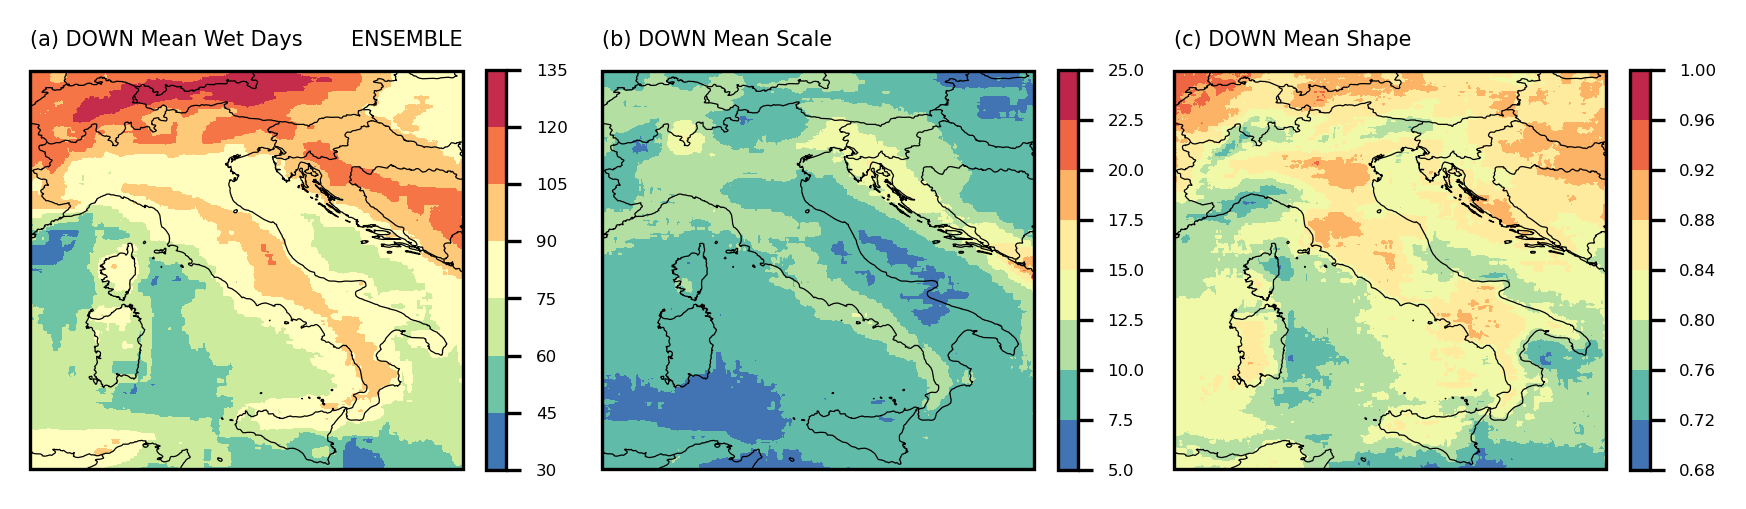

In [24]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(NYd_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) DOWN Mean Wet Days', fontsize=5, loc='left')
ax1.set_title(f'ENSEMBLE', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(CYd_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) DOWN Mean Scale', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(WYd_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) DOWN Mean Shape', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.15)

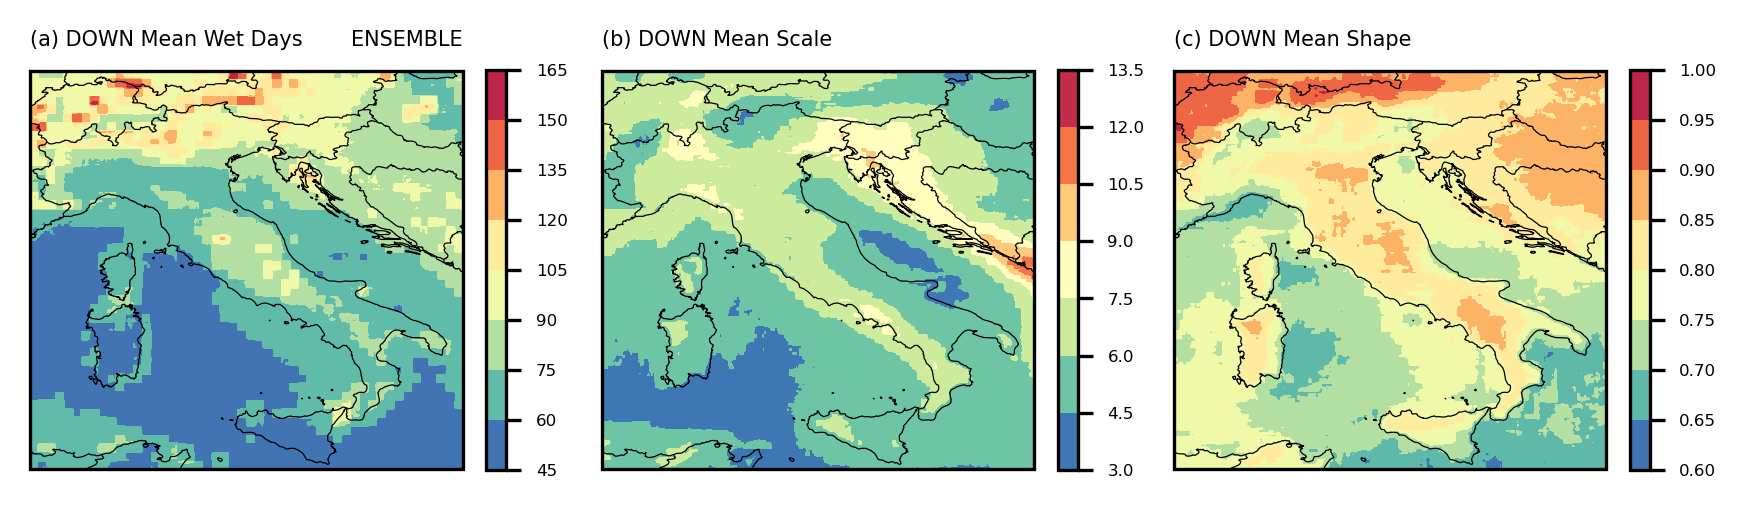

In [25]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(NYs_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) DOWN Mean Wet Days', fontsize=5, loc='left')
ax1.set_title(f'ENSEMBLE', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(CYs_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) DOWN Mean Scale', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(WYs_ensemble_mean,axis=0), cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) DOWN Mean Shape', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.15)

In [26]:
ENSEMBLE_Mev_d = ART_down.pre_quantiles_array(
                        NYd_ensemble_mean, 
                        CYd_ensemble_mean, 
                        WYd_ensemble_mean, 
                        Tr, 
                        lat_CH, lon_CH, 
                        1)

ENSEMBLE_Mev_s = ART_down.pre_quantiles_array(
                        NYs_ensemble_mean, 
                        CYs_ensemble_mean, 
                        WYs_ensemble_mean, 
                        Tr, 
                        lat_CH, lon_CH, 
                        1)

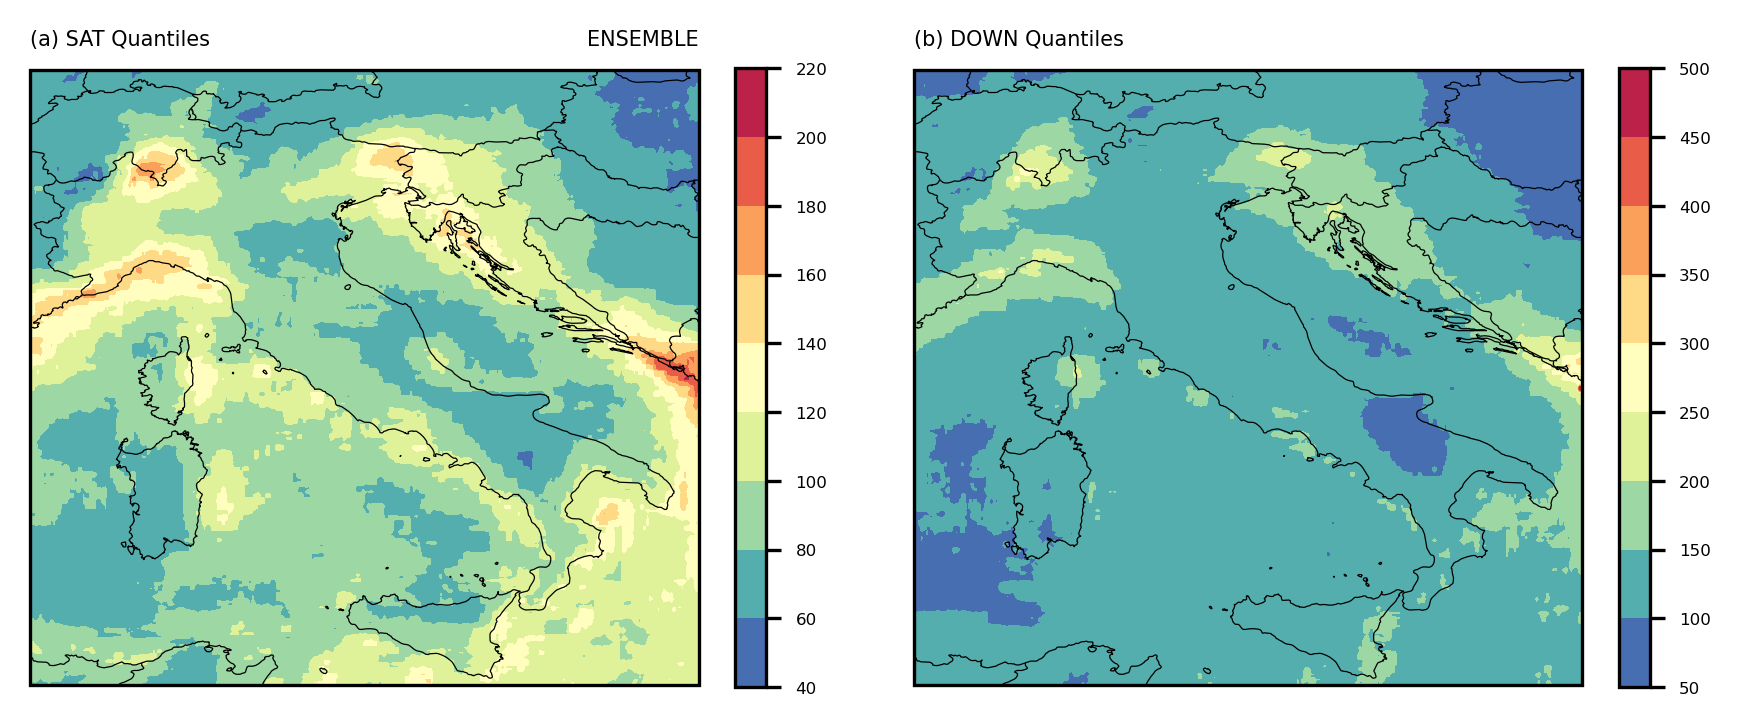

In [27]:
levelsQ = np.arange(20,380,20)
levelsQ = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(ENSEMBLE_Mev_s,axis=0), cmap=cmap, levels=levelsQ)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) SAT Quantiles', fontsize=5, loc='left')
ax1.set_title(f'ENSEMBLE', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(ENSEMBLE_Mev_d,axis=0), cmap=cmap, levels=levelsQ)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) DOWN Quantiles', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.15)

In [28]:
lon_min, lon_max, lat_min, lat_max, toll = 10.5, 13.5, 44.5, 47, 0.002

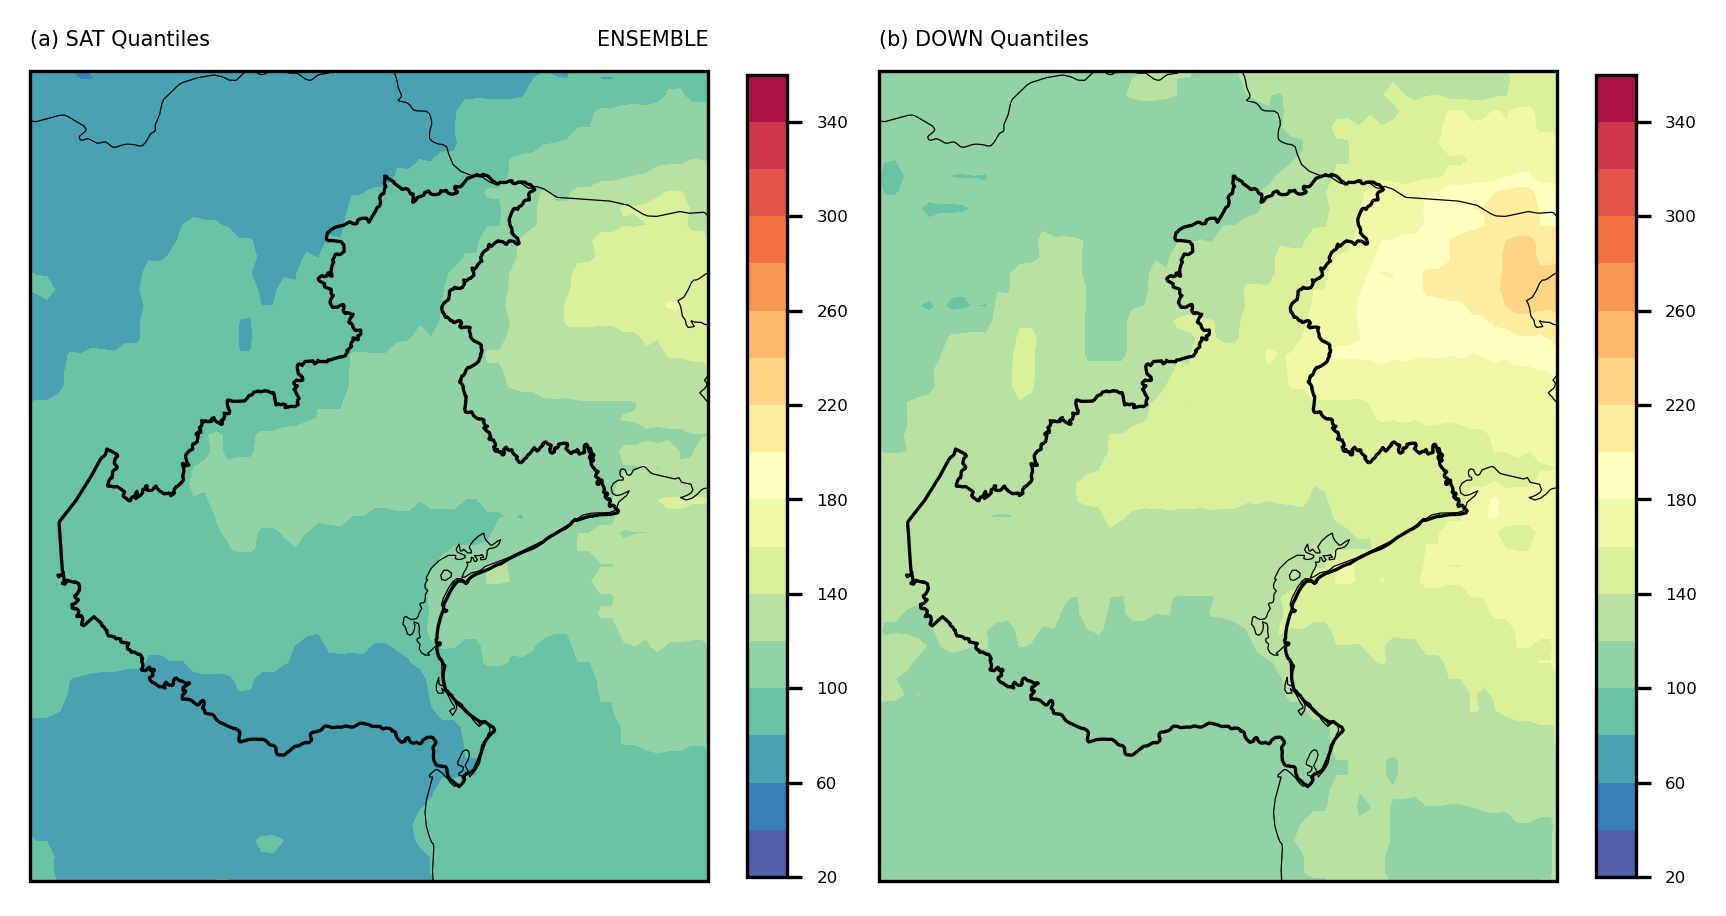

In [29]:
levelsQ = np.arange(20,380,20)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.8, zorder=10)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(ENSEMBLE_Mev_s,axis=0), cmap=cmap, levels=levelsQ)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.052)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) SAT Quantiles', fontsize=5, loc='left')
ax1.set_title(f'ENSEMBLE', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.8, zorder=10)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_CH, lat2d_CH, np.nanmean(ENSEMBLE_Mev_d,axis=0), cmap=cmap, levels=levelsQ)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.052)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) DOWN Quantiles', fontsize=5, loc='left')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.1, hspace=0.1)

In [30]:
ENSEMBLE_xr = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_ensemble_mean),
        "CYs": (("year","lat","lon"), CYs_ensemble_mean),
        "WYs": (("year","lat","lon"), WYs_ensemble_mean),
        "NYd": (("year","lat","lon"), NYd_ensemble_mean),
        "CYd": (("year","lat","lon"), CYd_ensemble_mean),
        "WYd": (("year","lat","lon"), WYd_ensemble_mean),
        "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mev_d),
        "Mev_s": (("Tr","lat","lon"), ENSEMBLE_Mev_s)
    },
    coords={
        'year': time_year, 
        'Tr': Tr, 
        'lat': lat_CH, 
        'lon': lon_CH
    },
    attrs=dict(description=f"ENSEMBLE of the downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid",)
)

ENSEMBLE_xr.NYs.attrs["units"] = "# days"
ENSEMBLE_xr.NYs.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYs.attrs["origname"] = "Sat Wet Days"

ENSEMBLE_xr.CYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYs.attrs["long_name"] = "Satellite Scale Parameter"
ENSEMBLE_xr.CYs.attrs["origname"] = "Sat Scale"

ENSEMBLE_xr.WYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYs.attrs["long_name"] = "Shape Parameter"
ENSEMBLE_xr.WYs.attrs["origname"] = "Sat Shape"

ENSEMBLE_xr.NYd.attrs["units"] = "# days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Satellite Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Down Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Downscaling Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Down Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Downscaling Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Down Shape"

ENSEMBLE_xr.Mev_s.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_s.attrs["long_name"] = "Satellite Extreme Quantiles"
ENSEMBLE_xr.Mev_s.attrs["origname"] = "Sat Ext-Quant"

ENSEMBLE_xr.Mev_d.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_d.attrs["long_name"] = "Downscaling Extreme Quantiles"
ENSEMBLE_xr.Mev_d.attrs["origname"] = "Down Ext-Quant"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [32]:
PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc'))
# PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_median.nc'))
# PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_NOGSMaP.nc'))
# PRE_out = os.path.join(os.path.join(dir_base, f'ITALY_ENSEMBLE_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_CHIRPS_CMORPH_IMERG.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/6_DOWN_corrected/ITALY_ENSEMBLE_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc


In [26]:
sys.exit()

SystemExit: 

## Manual method for compare 

In [ ]:
ENSEMBLE_manual = np.zeros_like(DATA_IM.Mev_d.values)
for i in range(len(lat_IM)):
    for j in range(len(lon_IM)):
        IM_vector = DATA_IM.Mev_d.values[:,i,j]

        distances = ART_pre.haversine(lat2d_CM, lon2d_CM, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        CM_vector = DATA_CM.Mev_d.values[:,min_index[0],min_index[1]]

        distances = ART_pre.haversine(lat2d_ER, lon2d_ER, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        ER_vector = DATA_ER.Mev_d.values[:,min_index[0],min_index[1]]

        distances = ART_pre.haversine(lat2d_GS, lon2d_GS, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        GS_vector = DATA_GS.Mev_d.values[:,min_index[0],min_index[1]]

        distances = ART_pre.haversine(lat2d_MS, lon2d_MS, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        MS_vector = DATA_MS.Mev_d.values[:,min_index[0],min_index[1]]

        ENSEMBLE_manual[:,i,j] = np.nanmean([IM_vector, CM_vector, ER_vector, GS_vector, MS_vector], axis=0)

Text(1.0, 1.0, 'Manual')

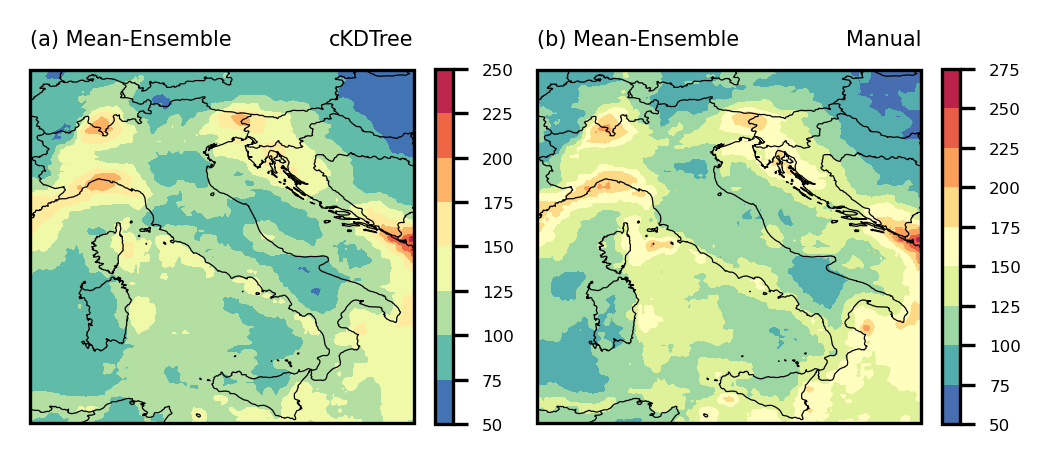

In [ ]:
index = 3

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,6),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, ENSEMBLE_Mev_d[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'cKDTree', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, ENSEMBLE_manual[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Manual', fontsize=5, loc='right')